In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, LatentDirichletAllocation
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support



In [2]:
data = fetch_20newsgroups()
print(data.target_names)
#fetching with train/test split-
x_test = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'), subset='test')
x_train = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'), subset='train')
y_test = x_test.target
test_target_names = x_test.target_names
train_target_names = x_train.target_names
y_train = x_train.target



x_test = x_test.data
x_train = x_train.data
#fixing dimensions (not working)
# x = np.array(x)
# y= np.array(y)
# x = x[:,np.newaxis]
# y = y[:,np.newaxis]

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [11]:
x_train[4000]

'\nThat depends entirely upon the advertiser whose number you circled.\nRadio Electronics compiles all of the cards, then each advertiser\ngets a computer printout of the names and addresses of all of the readers\nwho circled their number. Some magazines also provide the data on\nself-adhesive labels, and the really big magazines provide the\ndata on computer disk.\n\nThe advertiser decides what to do with the data they get. You will\nnotice that the Radio Electronics information card (commonly called\na "bingo card" in the industry) includes lines for a company name\nand a business phone number. My guess would be that the big, national\nadvertisers make a distinction between hobbiests and professionals as\nbest they can. For example, if you include Motorola as your company\nand include a business phone (and a mail stop), Tektronics will probably\nsend you a copy of their hard-bound catalog and have a sales engineer\ncall you about a week later. If you leave it blank, odds are they\nwi

[480 584 591 590 578 593 585 594 598 597 600 595 591 594 593 599 546 564
 465 377]


([<matplotlib.axis.XTick at 0x1acd8e95290>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19')])

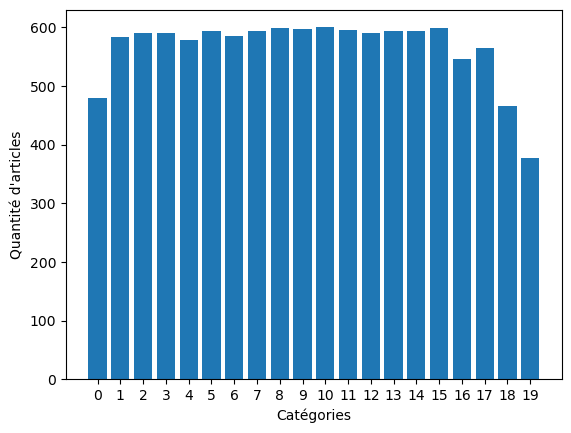

In [4]:
unique_labels = np.unique(data.target, return_counts=True)
print(unique_labels[1])
plt.bar(x=unique_labels[0], height=unique_labels[1])
plt.xlabel('Catégories')
plt.ylabel("Quantité d'articles")
plt.xticks(ticks=unique_labels[0])

In [3]:
cluster_number = len(np.unique(data.target))
cluster_number

20

In [13]:
# shamelessly stealing Adrien's nice function for clustering benchmark, with some twist:, 

def bench_clust(estimator, data, name, ground_truth = None):
    estimator.fit_transform(data)
    scores = [
        "adjusted_rand_score",
        "adjusted_mutual_info_score",
        "silhouette_score",
        "homogeneity_score",
        "completeness_score",
        "v_measure_score",
    ]
    results = []
    for s in scores:
        if s not in ["silhouette_score"]:
            #where ground truth is provided
            score = getattr(metrics, s)(ground_truth, estimator.labels_)
        elif ground_truth is not None:
            score = getattr(metrics, s)(data, estimator.labels_)
        else: 
            continue

        results.append(score)
    res = pd.DataFrame([results], columns=scores, index=[str(name)])
    return  res

In [14]:
# Another function for test set supervised metrics
def split_evaluation(estimator, data, name, ground_truth):
    y_hat = estimator.fit_predict(data)
    print(' '+25*'=' + f'{name} Metrics'+25*'=')
    accuracy = metrics.accuracy_score(ground_truth, y_hat)
    print(f' Accuracy : {accuracy=}')
    print('\ n Report : \n')
    report = metrics.classification_report(ground_truth, y_hat, target_names=test_target_names)
    print(report)
    print(50*'=')
    scores = [
        "adjusted_rand_score",
        "adjusted_mutual_info_score",
        "silhouette_score",
        "homogeneity_score",
        "completeness_score",
        "v_measure_score",
    ]
    results = []
    for s in scores:
        if s not in ["silhouette_score"]:
            #where ground truth is provided
            #get attribute to call 's' function in metrics
            score = getattr(metrics, s)(ground_truth, y_hat)
        elif ground_truth is not None:
            score = getattr(metrics, s)(data, estimator.labels_)
        else: 
            continue

        results.append(score)
    res = pd.DataFrame([results], columns=scores, index=[str(name)])
    return  res


In [15]:
#building train test split : 
# x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42)
# this method seems to be cumbersome to implement in this context, so we'll use the pre-splitted dataset directly

# failed to build a pipeline, it seems to cause a data dimension error that does not occur while working "the handy way", 
# # using CountVectorizer to extract tokens matrix, and kmeans as a model, in a sequence.
vect = CountVectorizer(max_features=10000, stop_words='english')
x_train_vec = vect.fit_transform(x_train)

model1 = KMeans(n_clusters= cluster_number)
#let's give it a try : 
res_train = bench_clust(model1, x_train_vec,'train_countvect and kmeans', y_train)
res_train

c:\Users\simplet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,adjusted_rand_score,adjusted_mutual_info_score,silhouette_score,homogeneity_score,completeness_score,v_measure_score
train_countvect and kmeans,-0.00001,0.002616,0.902567,0.003772,0.194768,0.0074


In [16]:
# using the test set
x_test_vec = vect.fit_transform(x_test)
res_test = split_evaluation(model1, x_test_vec,'test_countvect and kmeans' , y_test)
res_test

c:\Users\simplet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 =========================test_countvect and kmeans Metrics=========================
 Accuracy : accuracy=0.04753053637812002
\ n Report : 

                          precision    recall  f1-score   support

             alt.atheism       0.09      0.04      0.05       319
           comp.graphics       1.00      0.01      0.01       389
 comp.os.ms-windows.misc       0.00      0.00      0.00       394
comp.sys.ibm.pc.hardware       0.00      0.00      0.00       392
   comp.sys.mac.hardware       0.00      0.00      0.00       385
          comp.windows.x       0.00      0.00      0.00       395
            misc.forsale       0.00      0.00      0.00       390
               rec.autos       0.00      0.00      0.00       396
         rec.motorcycles       0.00      0.00      0.00       398
      rec.sport.baseball       0.00      0.00      0.00       397
        rec.sport.hockey       0.00      0.00      0.00       399
               sci.crypt       0.00      0.00      0.00       396


,adjusted_rand_score,adjusted_mutual_info_score,silhouette_score,homogeneity_score,completeness_score,v_measure_score
test_countvect and kmeans,0.000141,0.005784,0.787373,0.006327,0.153654,0.012153


In [17]:
#test with tfidf and stop_words

better_vec = TfidfVectorizer(stop_words='english', max_features=1000)
x_train_vec2 = better_vec.fit_transform(x_train)
model2 = KMeans(n_clusters= cluster_number)
#let's give it a try : 
res_train_2 = bench_clust(model2, x_train_vec2, 'train tdidf and kmeans', y_train)
res_train_2

c:\Users\simplet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,adjusted_rand_score,adjusted_mutual_info_score,silhouette_score,homogeneity_score,completeness_score,v_measure_score
train tdidf and kmeans,0.032277,0.197285,0.001242,0.161308,0.26952,0.201824


In [18]:
#using the test set
x_test_vec2 = better_vec.fit_transform(x_test)
res_test_2 = split_evaluation(model2, x_test_vec2, 'test tdidf and kmeans', y_test)
res_test_2

c:\Users\simplet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 =========================test tdidf and kmeans Metrics=========================
 Accuracy : accuracy=0.04633563462559745
\ n Report : 

                          precision    recall  f1-score   support

             alt.atheism       0.01      0.01      0.01       319
           comp.graphics       0.04      0.20      0.06       389
 comp.os.ms-windows.misc       0.00      0.00      0.00       394
comp.sys.ibm.pc.hardware       0.00      0.00      0.00       392
   comp.sys.mac.hardware       0.06      0.03      0.04       385
          comp.windows.x       0.00      0.00      0.00       395
            misc.forsale       0.05      0.01      0.02       390
               rec.autos       0.08      0.06      0.07       396
         rec.motorcycles       0.08      0.15      0.11       398
      rec.sport.baseball       0.01      0.00      0.00       397
        rec.sport.hockey       0.02      0.03      0.02       399
               sci.crypt       0.02      0.03      0.02       396
    

,adjusted_rand_score,adjusted_mutual_info_score,silhouette_score,homogeneity_score,completeness_score,v_measure_score
test tdidf and kmeans,0.046903,0.2147,0.013896,0.205467,0.240551,0.221629


In [34]:
# i'm curious of the impact of max_df argument on performances, benchmarking it
#### Don't Run this cell unless you want to take a long break #####
df_res = pd.DataFrame()
model = KMeans(n_clusters=cluster_number, random_state=42)
for i in range(70):
    n= 1 - (i/100)
    better_vec = TfidfVectorizer(max_df=n)
    x_train_vec2 = better_vec.fit_transform(x_train)
    results = bench_clust(model, x_train_vec2, n, y_train)
    df_res = pd.concat([df_res, results], axis=0, ignore_index=False)
df_res

c:\Users\simplet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\simplet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\simplet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\simplet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the 

,adjusted_rand_score,adjusted_mutual_info_score,silhouette_score,homogeneity_score,completeness_score,v_measure_score
1.0,0.049280,0.181444,-0.007702,0.172633,0.202371,0.186323
0.99,0.049280,0.181444,-0.007702,0.172633,0.202371,0.186323
0.98,0.049280,0.181444,-0.007702,0.172633,0.202371,0.186323
0.97,0.049280,0.181444,-0.007702,0.172633,0.202371,0.186323
0.96,0.049280,0.181444,-0.007702,0.172633,0.202371,0.186323
...,...,...,...,...,...,...
0.35,0.066535,0.257262,0.000977,0.241449,0.285491,0.261629
0.33999999999999997,0.070429,0.255018,-0.000587,0.241282,0.280372,0.259363
0.32999999999999996,0.069889,0.275061,0.001842,0.255572,0.308080,0.279380
0.31999999999999995,0.069889,0.275061,0.001842,0.255572,0.308080,0.279380


In [59]:
df_res.index = df_res.index.astype('float')
df_res.index = df_res.index.to_series().round(2)

Text(0, 0.5, 'score')

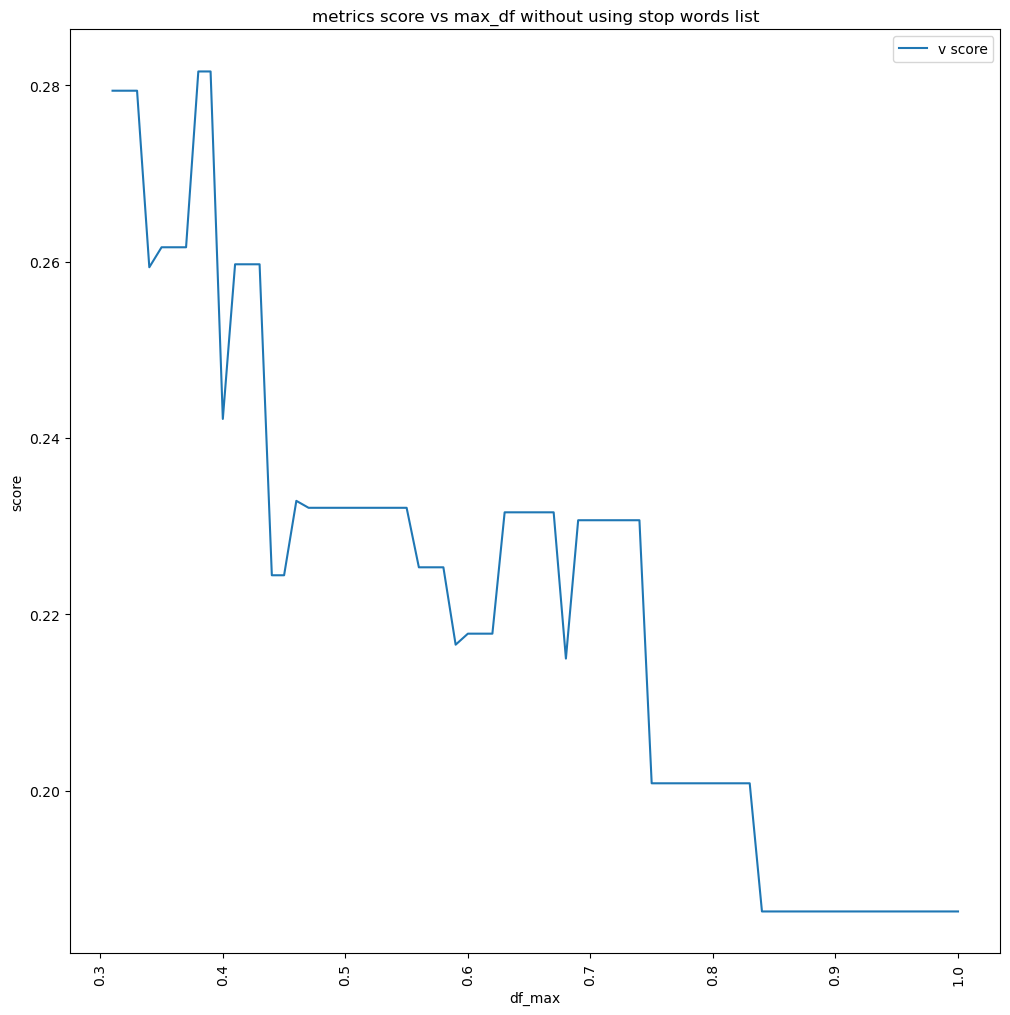

In [60]:
#plotting metrics vs max_df
plt.figure(figsize=(12,12))
plt.plot(df_res.index, df_res['v_measure_score'], label = 'v score')
# plt.plot(df_res.index, df_res['silhouette_score'], label = 'silhouette score')
# plt.plot(df_res.index, df_res['adjusted_mutual_info_score'], label = 'AMI')
plt.legend()
plt.xlabel('df_max')
plt.title('metrics score vs max_df without using stop words list')
plt.xticks(rotation = 90)
plt.ylabel('score')

In [36]:
#running the benchmark again with the stop words list 
df_res2 = pd.DataFrame()
for i in range(70):
    n= 1 - (i/100)
    better_vec = TfidfVectorizer(max_df=n, stop_words='english')
    x_train_vec2 = better_vec.fit_transform(x_train)
    results = bench_clust(model, x_train_vec2, n, y_train)
    df_res2 = pd.concat([df_res2, results], axis=0, ignore_index=False)
df_res2

c:\Users\simplet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\simplet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\simplet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\simplet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the 

,adjusted_rand_score,adjusted_mutual_info_score,silhouette_score,homogeneity_score,completeness_score,v_measure_score
1.0,0.065151,0.320596,0.005923,0.286905,0.374198,0.324788
0.99,0.065151,0.320596,0.005923,0.286905,0.374198,0.324788
0.98,0.065151,0.320596,0.005923,0.286905,0.374198,0.324788
0.97,0.065151,0.320596,0.005923,0.286905,0.374198,0.324788
0.96,0.065151,0.320596,0.005923,0.286905,0.374198,0.324788
...,...,...,...,...,...,...
0.35,0.065151,0.320596,0.005923,0.286905,0.374198,0.324788
0.33999999999999997,0.065151,0.320596,0.005923,0.286905,0.374198,0.324788
0.32999999999999996,0.065151,0.320596,0.005923,0.286905,0.374198,0.324788
0.31999999999999995,0.065151,0.320596,0.005923,0.286905,0.374198,0.324788


In [61]:
df_res2.index = df_res2.index.astype('float')
df_res2.index = df_res2.index.to_series().round(2)

Text(0, 0.5, 'score')

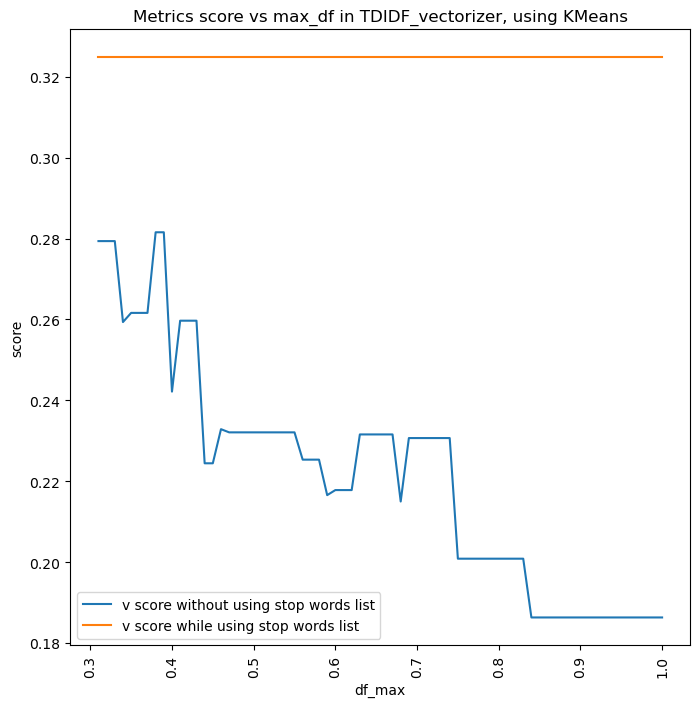

In [67]:
#plotting metrics vs max_df
plt.figure(figsize=(8,8))
plt.plot(df_res.index, df_res['v_measure_score'], label = 'v score without using stop words list')
plt.plot(df_res2.index, df_res2['v_measure_score'], label = 'v score while using stop words list')
# plt.plot(df_res2.index, df_res2['silhouette_score'], label = 'silhouette score')
# plt.plot(df_res2.index, df_res2['adjusted_mutual_info_score'], label = 'AMI')
plt.legend()
plt.title('Metrics score vs max_df in TDIDF_vectorizer, using KMeans')
plt.xlabel('df_max')
plt.xticks(rotation = 90)
plt.ylabel('score')

In [34]:
#test with tfidf and playing with vectorizer parameters

better_vec2 = TfidfVectorizer(stop_words='english', 
                              max_df=0.8,
                              min_df=20
                              )
x_train_vec2 = better_vec2.fit_transform(x_train)
model3= KMeans(n_clusters= cluster_number, random_state=42)
res = bench_clust(model3, x_train_vec2, 'kmeans and tdidf', y_train)
res

c:\Users\simplet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,adjusted_rand_score,adjusted_mutual_info_score,silhouette_score,homogeneity_score,completeness_score,v_measure_score
kmeans and tdidf,0.065656,0.327772,0.010687,0.29672,0.376428,0.331855


<Axes: ylabel='Count'>

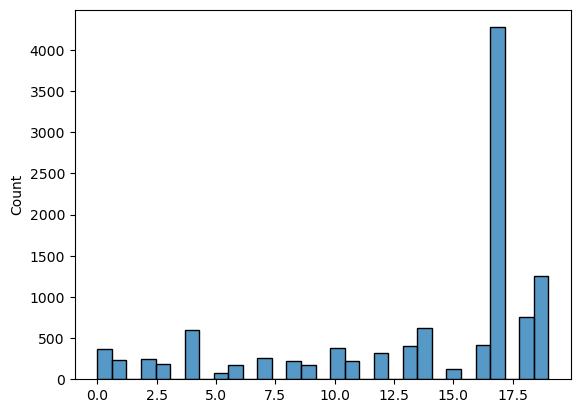

In [33]:
#Results hist
labels = model3.labels_
sns.histplot(data= labels)

In [90]:
#test set
res_test_3 = split_evaluation(model3, x_test_vec2, 'test tdidf and kmeans', y_test)
res_test_3

c:\Users\simplet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 =========================test tdidf and kmeans Metrics=========================
 Accuracy : accuracy=0.025491237387148168
\ n Report : 

                          precision    recall  f1-score   support

             alt.atheism       0.01      0.00      0.00       319
           comp.graphics       0.01      0.01      0.01       389
 comp.os.ms-windows.misc       0.00      0.00      0.00       394
comp.sys.ibm.pc.hardware       0.00      0.01      0.01       392
   comp.sys.mac.hardware       0.02      0.01      0.02       385
          comp.windows.x       0.15      0.07      0.10       395
            misc.forsale       0.04      0.19      0.06       390
               rec.autos       0.05      0.05      0.05       396
         rec.motorcycles       0.01      0.01      0.01       398
      rec.sport.baseball       0.07      0.04      0.05       397
        rec.sport.hockey       0.05      0.04      0.04       399
               sci.crypt       0.00      0.00      0.00       396
   

,adjusted_rand_score,adjusted_mutual_info_score,silhouette_score,homogeneity_score,completeness_score,v_measure_score
test tdidf and kmeans,0.062406,0.233215,0.011642,0.22468,0.25731,0.239891


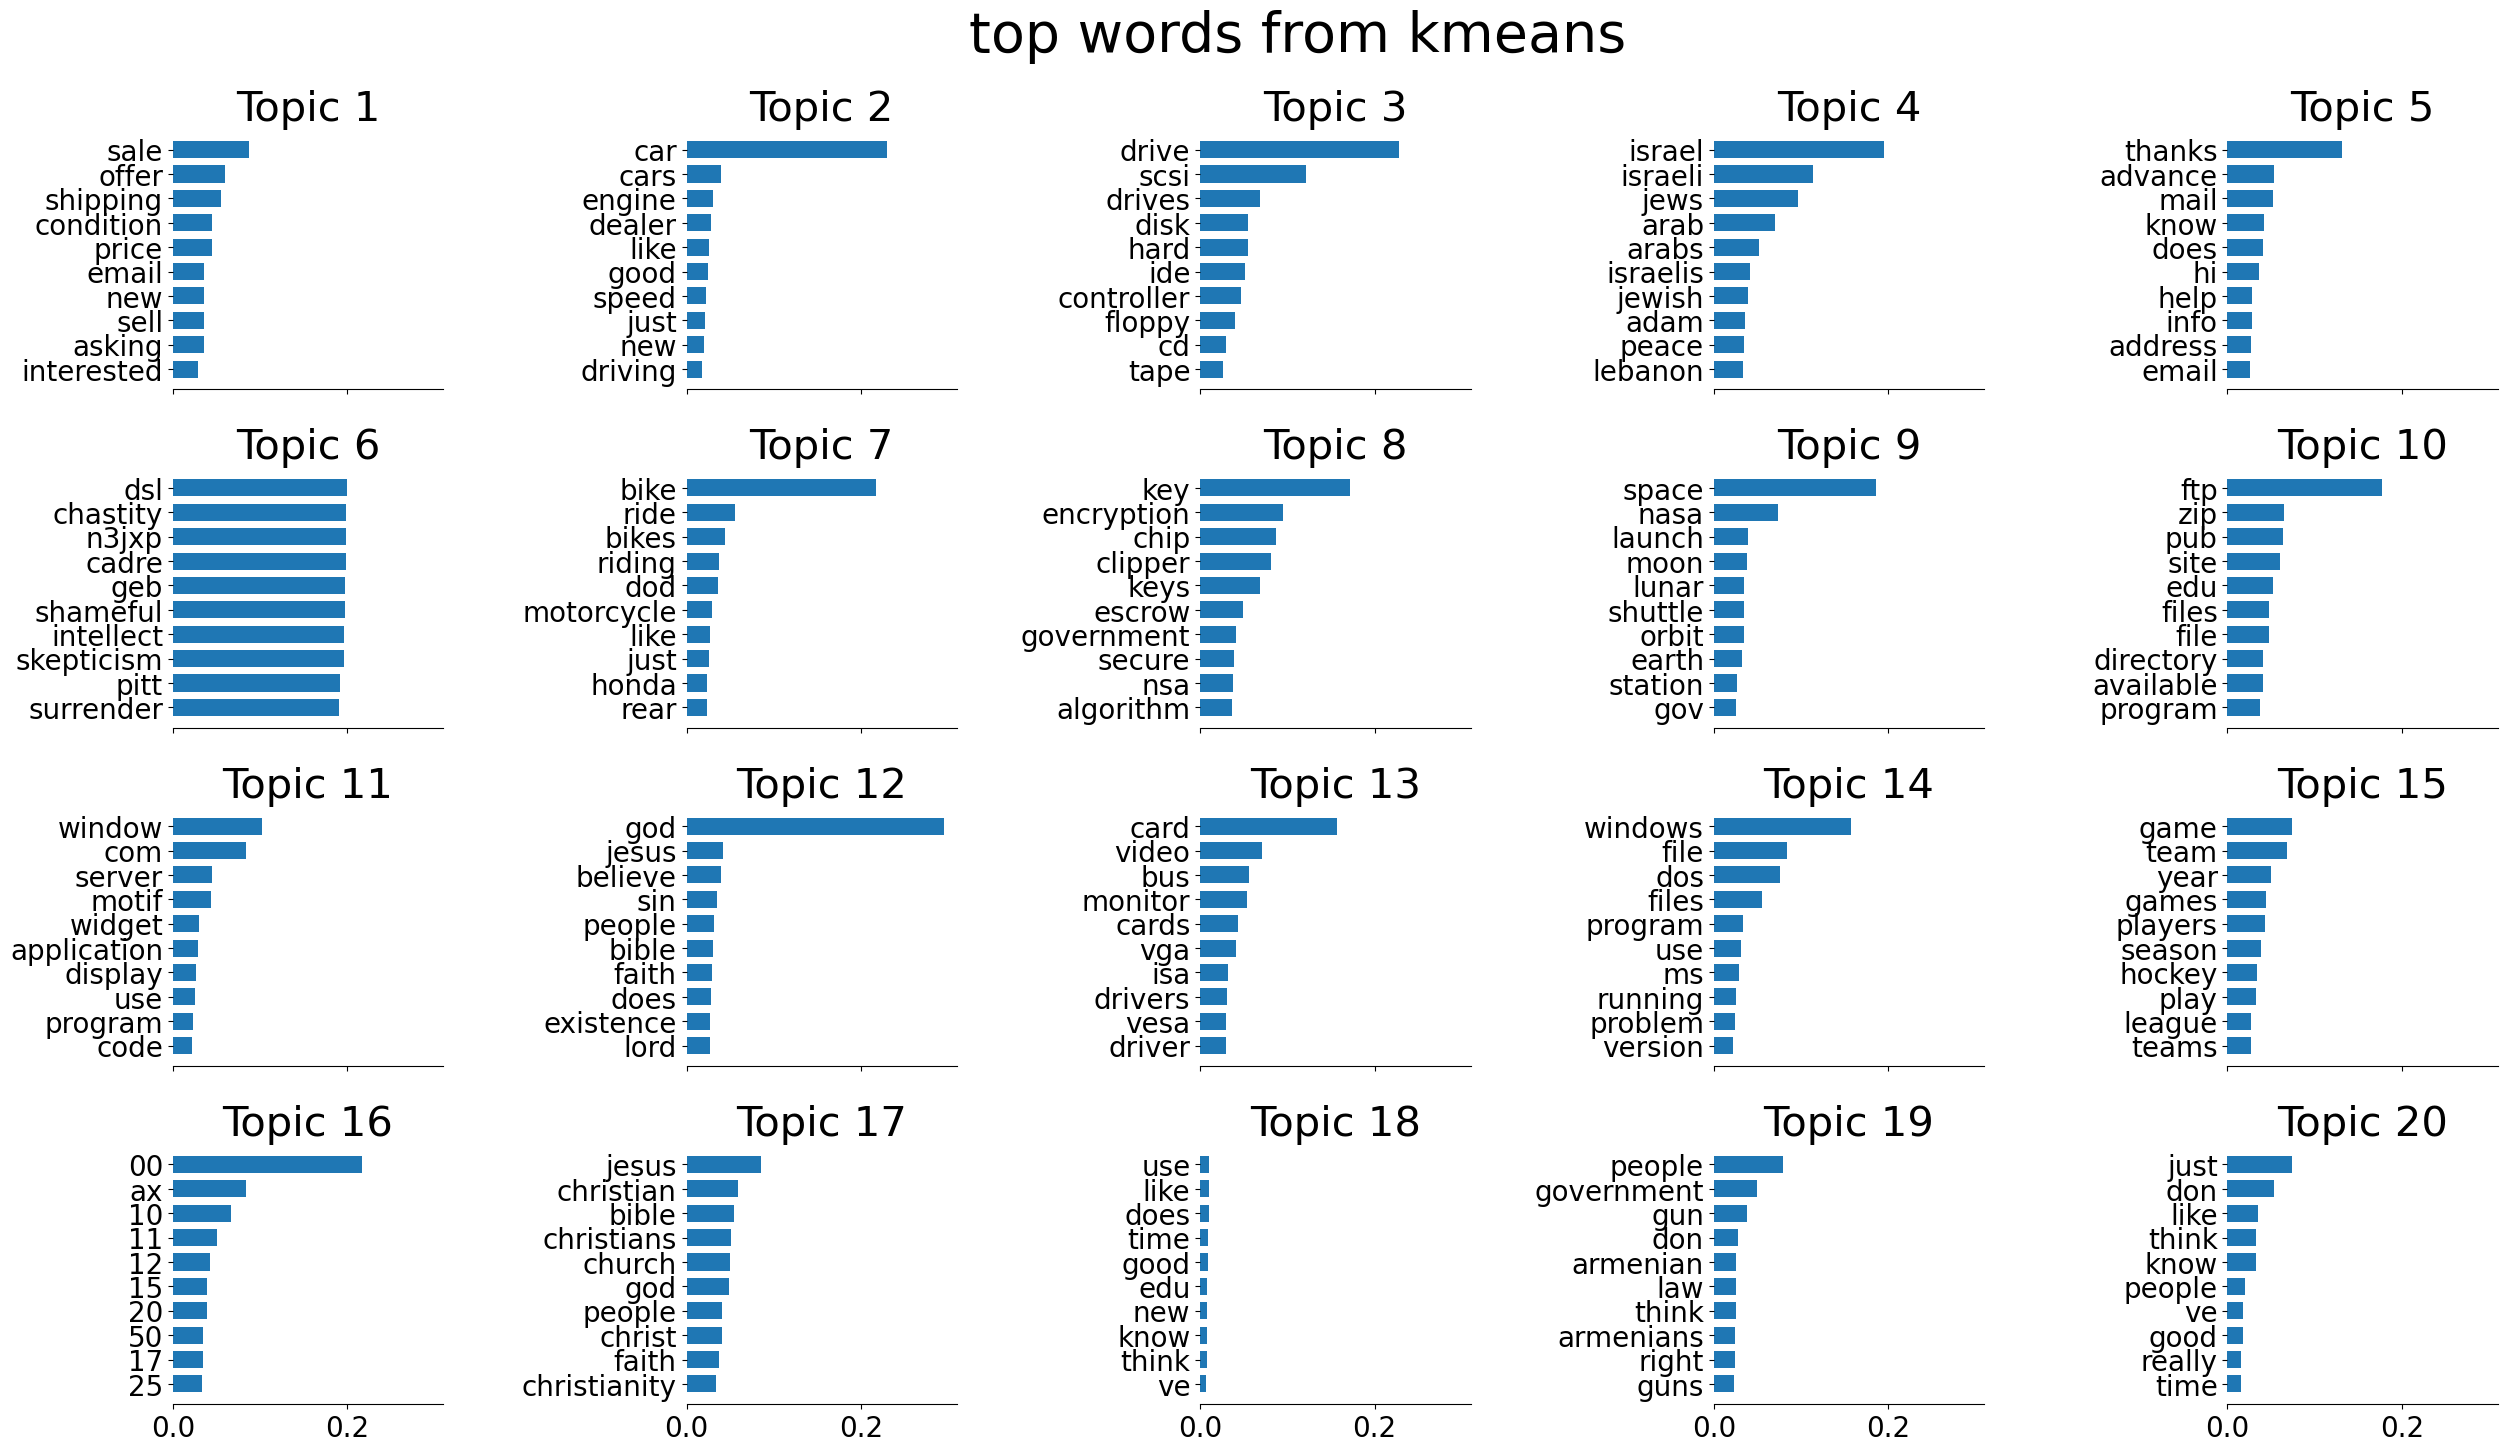

In [35]:
# extracting top 10 words 

# order_centroids = model.cluster_centers_.argsort()[:, ::-1]
# terms = vect.get_feature_names_out()
# for i in range(cluster_number):
#     print('Cluster %d:' %(i+1))
#     for ind in order_centroids[i, :10]:
#         print(' %s' % terms[ind])

# for plotting topics in kmeans
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.cluster_centers_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

terms = better_vec2.get_feature_names_out()
plot_top_words(model3, terms, 10, 'top words from kmeans')

In [109]:
#how long is the stopped words? 
sw = better_vec2.stop_words_
len(sw)

942734

In [28]:
#Avec LDA

better_vec3 = CountVectorizer(stop_words='english')
x_train_vec3 = better_vec3.fit_transform(x_train)
x_test_vec3 = better_vec3.transform(x_test)
LDA = LatentDirichletAllocation(n_components=20, n_jobs=-1)
LDA.set_output(transform='pandas')
y_hat = LDA.fit_transform(x_train_vec3)
LDA.score(x_train_vec3)
y_hat_test = LDA.transform(x_test_vec3)


In [6]:
#LDA returns probability of x being in the class y
y_hat

,latentdirichletallocation0,latentdirichletallocation1,latentdirichletallocation2,latentdirichletallocation3,latentdirichletallocation4,latentdirichletallocation5,latentdirichletallocation6,latentdirichletallocation7,latentdirichletallocation8,latentdirichletallocation9,latentdirichletallocation10,latentdirichletallocation11,latentdirichletallocation12,latentdirichletallocation13,latentdirichletallocation14,latentdirichletallocation15,latentdirichletallocation16,latentdirichletallocation17,latentdirichletallocation18,latentdirichletallocation19
0,0.009575,0.009575,0.009575,0.009575,0.009575,0.009575,0.009575,0.009575,0.009575,0.009575,0.009575,0.009575,0.009575,0.009575,0.009575,0.818075,0.009575,0.009575,0.009575,0.009575
1,0.008833,0.008833,0.008833,0.008833,0.056265,0.008833,0.008833,0.008833,0.008833,0.008833,0.008833,0.008833,0.008833,0.008833,0.008833,0.243873,0.549702,0.008833,0.008833,0.008833
2,0.005355,0.005355,0.005355,0.005355,0.005355,0.005355,0.005355,0.005355,0.005355,0.005355,0.005355,0.005355,0.005355,0.005355,0.005355,0.898262,0.005355,0.005355,0.005355,0.005355
3,0.014668,0.014668,0.014668,0.014668,0.555258,0.014668,0.014668,0.014668,0.014668,0.014668,0.180718,0.014668,0.014668,0.014668,0.014668,0.014668,0.014668,0.014668,0.014668,0.014668
4,0.008795,0.008795,0.832894,0.008795,0.008795,0.008795,0.008795,0.008795,0.008795,0.008795,0.008795,0.008795,0.008795,0.008795,0.008795,0.008795,0.008795,0.008795,0.008795,0.008795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11309,0.006828,0.006828,0.006828,0.006828,0.006828,0.006828,0.006828,0.006828,0.006828,0.006828,0.006828,0.006828,0.006828,0.006828,0.006828,0.870262,0.006828,0.006828,0.006828,0.006828
11310,0.008163,0.008163,0.008163,0.008163,0.008163,0.008163,0.008163,0.008163,0.008163,0.008163,0.008163,0.008163,0.008163,0.008163,0.008163,0.228568,0.624503,0.008163,0.008163,0.008163
11311,0.014318,0.014318,0.014318,0.014318,0.014318,0.014318,0.014318,0.014318,0.014318,0.014318,0.014318,0.014318,0.014318,0.014318,0.014318,0.165494,0.576780,0.014318,0.014318,0.014318
11312,0.802538,0.010393,0.010393,0.010393,0.010393,0.010393,0.010393,0.010393,0.010393,0.010393,0.010393,0.010393,0.010393,0.010393,0.010393,0.010393,0.010393,0.010393,0.010393,0.010393


In [29]:
y_hat.columns = range(20)
y_hat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.602111,0.001852,0.001852,0.001852,0.001852,0.250864,0.001852,0.001852,0.001852,0.001852,0.001852,0.001852,0.001852,0.001852,0.001852,0.115543,0.001852,0.001852,0.001852,0.001852
1,0.200835,0.001786,0.001786,0.001786,0.147160,0.108696,0.001786,0.001786,0.001786,0.001786,0.001786,0.001786,0.001786,0.001786,0.001786,0.001786,0.514738,0.001786,0.001786,0.001786
2,0.156725,0.000485,0.000485,0.000485,0.000485,0.273858,0.000485,0.000485,0.327744,0.000485,0.000485,0.000485,0.000485,0.044285,0.000485,0.000485,0.000485,0.190107,0.000485,0.000485
3,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.513050,0.358379,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143
4,0.001724,0.040095,0.001724,0.245127,0.001724,0.001724,0.001724,0.001724,0.262919,0.001724,0.424272,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724,0.001724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11309,0.061941,0.000943,0.000943,0.047330,0.000943,0.000943,0.000943,0.000943,0.874691,0.000943,0.000943,0.000943,0.000943,0.000943,0.000943,0.000943,0.000943,0.000943,0.000943,0.000943
11310,0.001471,0.001471,0.001471,0.001471,0.001471,0.497748,0.001471,0.001471,0.001471,0.001471,0.001471,0.001471,0.001471,0.001471,0.001471,0.001471,0.084713,0.392539,0.001471,0.001471
11311,0.001852,0.001852,0.001852,0.001852,0.001852,0.001852,0.001852,0.001852,0.279309,0.001852,0.001852,0.001852,0.001852,0.001852,0.001852,0.001852,0.687358,0.001852,0.001852,0.001852
11312,0.002632,0.108523,0.002632,0.002632,0.002632,0.002632,0.002632,0.002632,0.002632,0.002632,0.002632,0.002632,0.002632,0.233694,0.002632,0.002632,0.002632,0.002632,0.613046,0.002632


In [30]:
y_hat_test.columns = range(20)
#extracting max probability for each articles
maxindex_train = y_hat.idxmax(axis=1)
maxindex_test = y_hat_test.idxmax(axis=1)

In [31]:
accuracy_LDA = accuracy_score(y_test, maxindex_test)
print(f'{accuracy_LDA=}')
report_LDA = classification_report(y_test, maxindex_test, target_names= test_target_names)
print(report_LDA)

accuracy_LDA=0.044078597981943704
                          precision    recall  f1-score   support

             alt.atheism       0.04      0.11      0.05       319
           comp.graphics       0.04      0.01      0.01       389
 comp.os.ms-windows.misc       0.00      0.00      0.00       394
comp.sys.ibm.pc.hardware       0.02      0.01      0.01       392
   comp.sys.mac.hardware       0.00      0.00      0.00       385
          comp.windows.x       0.03      0.06      0.04       395
            misc.forsale       0.01      0.00      0.00       390
               rec.autos       0.04      0.01      0.01       396
         rec.motorcycles       0.09      0.39      0.15       398
      rec.sport.baseball       0.00      0.00      0.00       397
        rec.sport.hockey       0.00      0.00      0.00       399
               sci.crypt       0.03      0.03      0.03       396
         sci.electronics       0.03      0.03      0.03       393
                 sci.med       0.00      

c:\Users\simplet\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\simplet\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\simplet\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Distribution avec LDA')

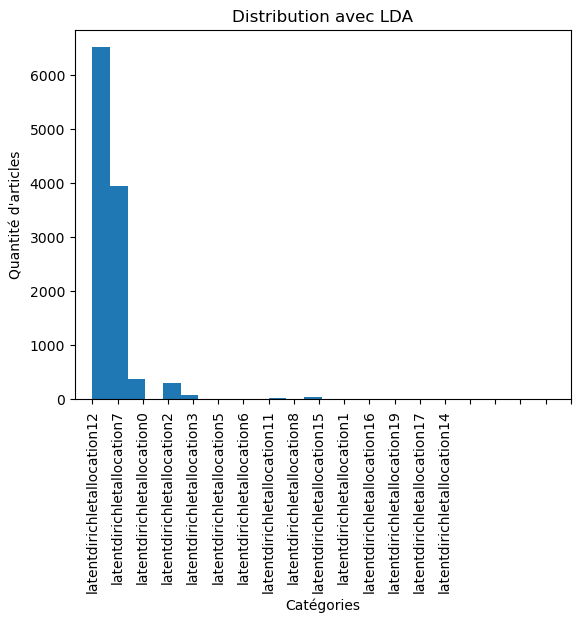

In [55]:
# plotting results distribution
plt.hist(maxindex, bins = 20)
plt.xlabel('Catégories')
plt.ylabel("Quantité d'articles")
plt.xticks(ticks=range(20), rotation = 90)
plt.title('Distribution avec LDA')

In [56]:
#function ripped from :
#https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
# for plotting topics in LDA
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

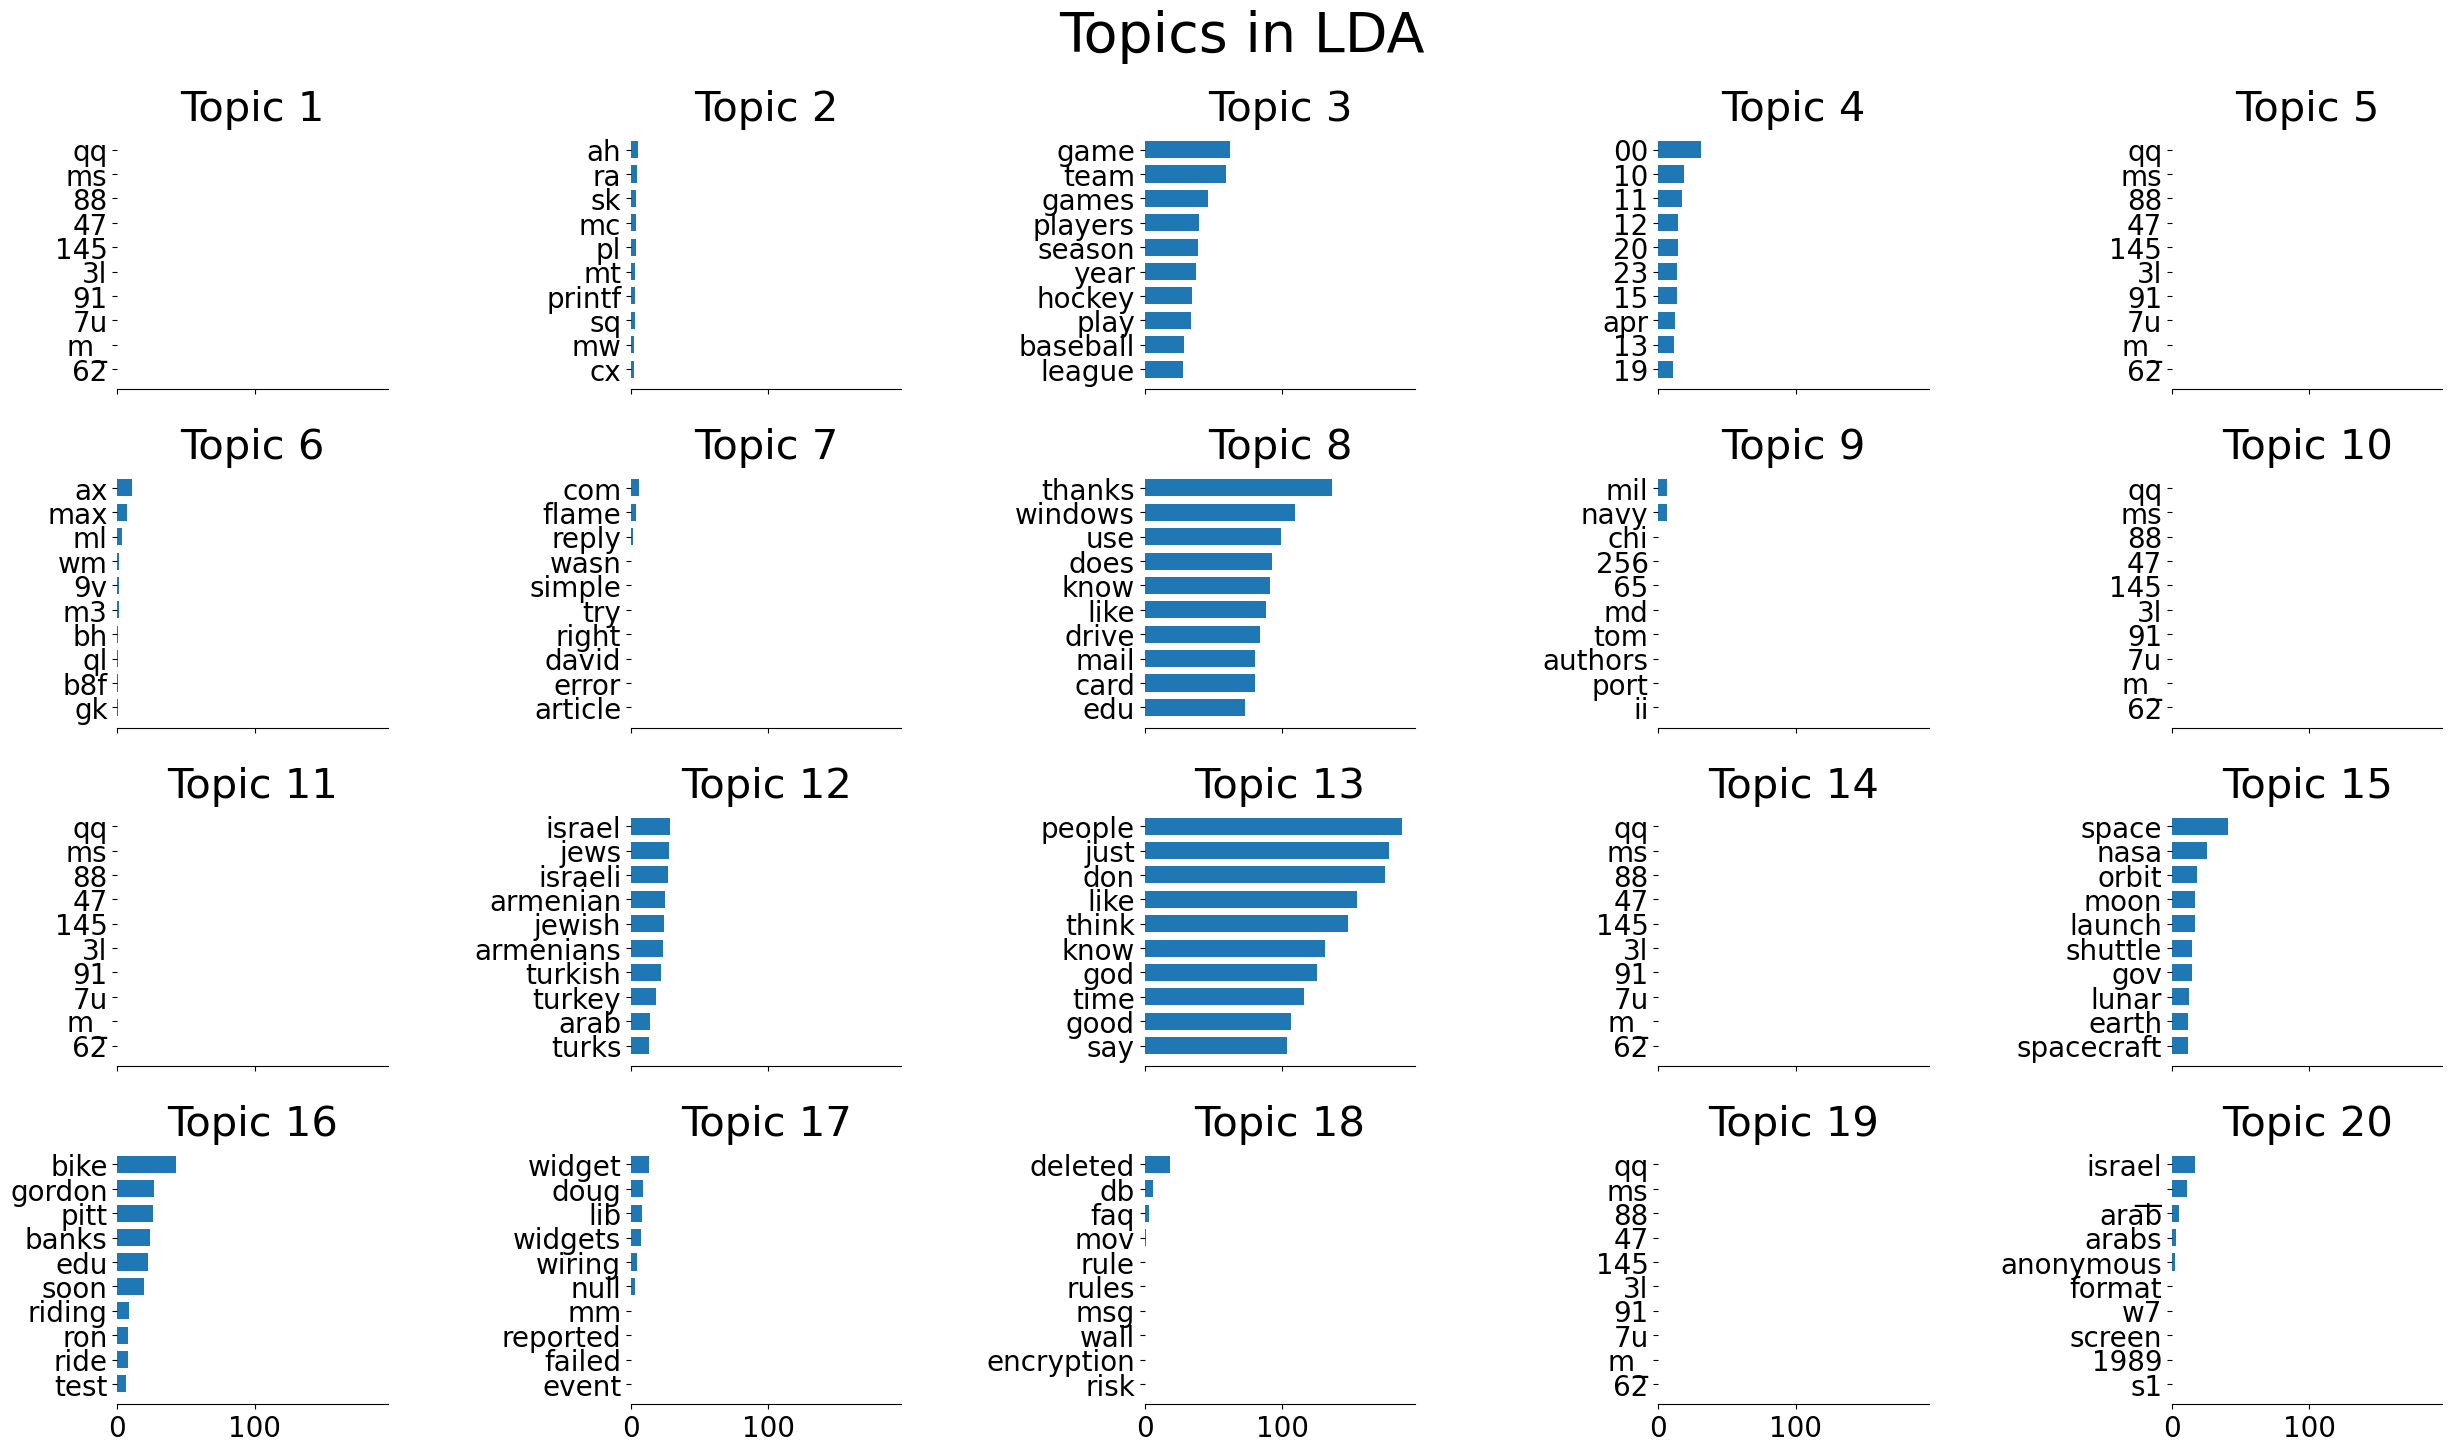

In [57]:
#extracting features from vectors and plotting topics
tf_feature_names = better_vec3.get_feature_names_out()
plot_top_words(LDA, tf_feature_names, 10, "Topics in LDA")

In [12]:
#At this point, i've done so many trials/errors and changes to the notebook, things stop to make sense. i should start over from scratch
#as i won't do that, let's try some classification for desert
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
#réduction de dimension
better_vec4 = TfidfVectorizer(stop_words='english', 
                              token_pattern=r'[A-Za-z][A-Za-z][A-Za-z]+')
x_train_vec4 = better_vec4.fit_transform(x_train)
x_test_vec4 = better_vec4.transform(x_test)

pca= PCA(n_components=100)
x_train_reduced = pca.fit_transform(x_train_vec4.toarray())
x_test_reduced = pca.transform(x_test_vec4.toarray())
# plt.plot(pca.singular_values_)

In [13]:
model_class = SVC()
model_class.fit(x_train_reduced, y_train)
y_hat_NB = model_class.predict(x_test_reduced)
accuracy_NB = accuracy_score(y_test, y_hat_NB)
print(f'{accuracy_NB=}')
report = classification_report(y_test, y_hat_NB, target_names= test_target_names)
print(report)

accuracy_NB=0.6030270844397239
                          precision    recall  f1-score   support

             alt.atheism       0.36      0.41      0.38       319
           comp.graphics       0.54      0.65      0.59       389
 comp.os.ms-windows.misc       0.61      0.57      0.59       394
comp.sys.ibm.pc.hardware       0.57      0.53      0.55       392
   comp.sys.mac.hardware       0.64      0.57      0.60       385
          comp.windows.x       0.76      0.61      0.67       395
            misc.forsale       0.74      0.72      0.73       390
               rec.autos       0.38      0.68      0.49       396
         rec.motorcycles       0.64      0.65      0.65       398
      rec.sport.baseball       0.74      0.76      0.75       397
        rec.sport.hockey       0.91      0.78      0.84       399
               sci.crypt       0.84      0.62      0.71       396
         sci.electronics       0.45      0.47      0.46       393
                 sci.med       0.60      0.6

<Axes: >

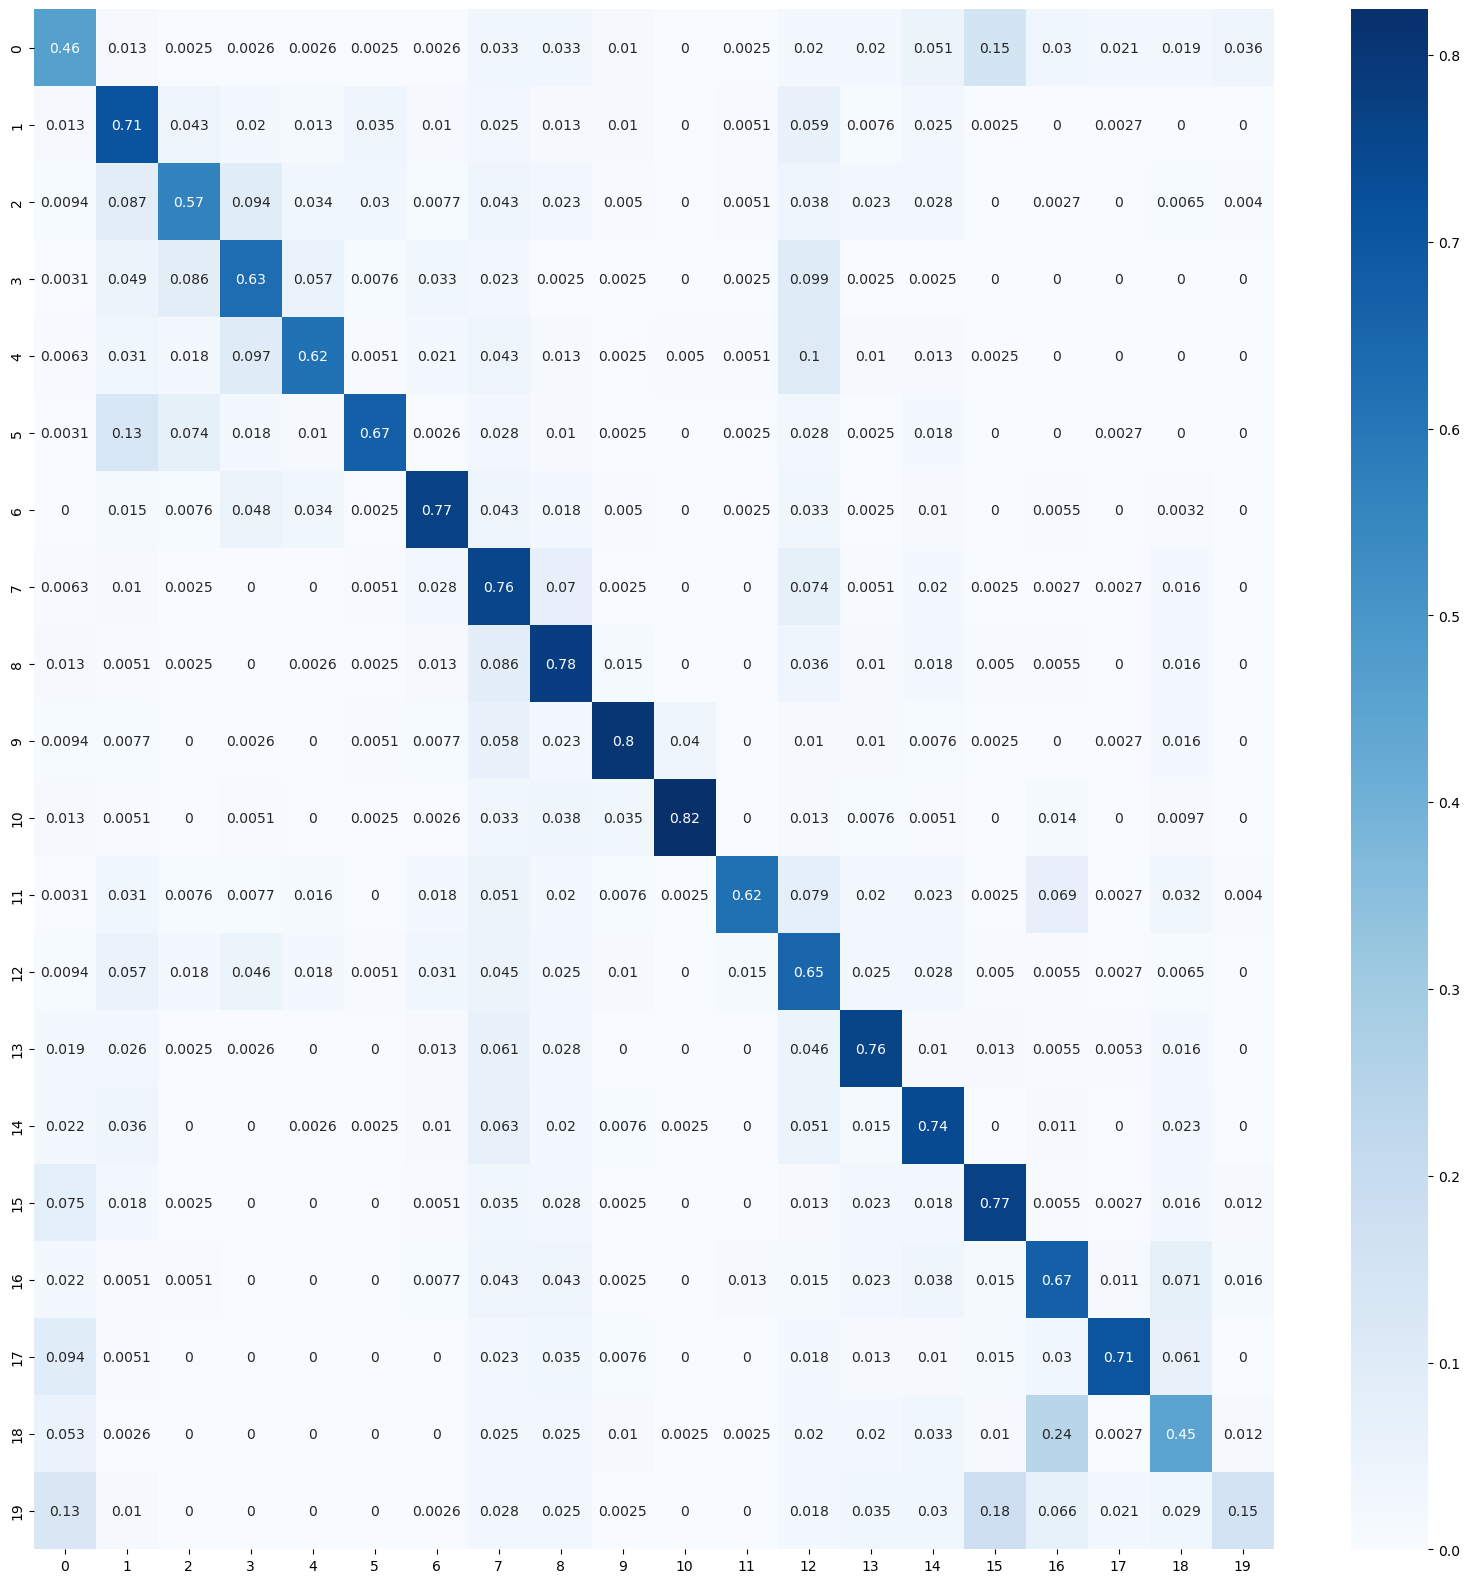

In [10]:
conf_matrix = confusion_matrix(y_test, y_hat_NB)
conf_matrix = conf_matrix/ conf_matrix.sum(axis = 1)
plt.figure(figsize=(20,20))
sns.heatmap(conf_matrix, cmap='Blues', annot=True)

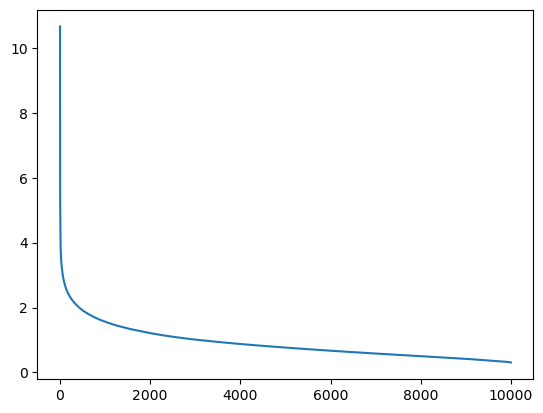

In [18]:
#Exactly the same with truncated svd
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=10000)
x_train_svdreduced = tsvd.fit_transform(x_train_vec4)
x_test_svdreduced = tsvd.transform(x_test_vec4)
plt.plot(tsvd.singular_values_)

In [19]:
model_class = SVC()
model_class.fit(x_train_svdreduced, y_train)
y_hat_NB = model_class.predict(x_test_svdreduced)
accuracy_NB = accuracy_score(y_test, y_hat_NB)
print(f'{accuracy_NB=}')
report = classification_report(y_test, y_hat_NB, target_names= test_target_names)
print(report)